<a href="https://colab.research.google.com/github/saimasharleen/Active-Learning-Strategies-Across-Diverse-Machine-Learning-Models/blob/main/MNIST_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-lkyhyudl
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-lkyhyudl
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.3 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=d5de9d0f44c6c26dc8766c4c41ccc38f688f893032c202624b56b7cd0a93ab74
  Stored in directory: /tmp/pip-ephem-wheel-cache-lrqgj2a1/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [2]:
import numpy as np
import joblib
import collections
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [3]:
# Load MNIST data
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
x, y = next(iter(dataloader))

100%|██████████| 9912422/9912422 [00:00<00:00, 98668177.40it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65478753.42it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27305858.84it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9650723.79it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Preprocessing
x = x.detach().cpu().numpy().reshape(x.size(0), -1)  # Flatten the images
y = y.detach().cpu().numpy()

In [5]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0, stratify=y)


In [6]:
# Define confusion matrix print function
def CF_Print(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    CF = confusion_matrix(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print('Confusion Matrix:')
    print(CF)
    print('Accuracy: ', accuracy)
    print('Macro F1-score: ', macro_f1)
    print('Micro F1-score: ', micro_f1)
    print('Weighted F1-score: ', weighted_f1)
    print("---------------------------------")


In [7]:
# Active Learning with Decision Tree
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    # Initialize the learner
    learner = ActiveLearner(
        estimator=DecisionTreeClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    print("Number of initial data: ", n_initial)
    y_pred = learner.predict(x_test)
    CF_Print(y_test, y_pred)

    # Active Learning Loop
    for idx in range(n_queries):
        print('--- Query no: ', idx+1, ' ----')
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
        print('Instance', y_pool[query_idx])
        y_pred = learner.predict(x_test)
        CF_Print(y_test, y_pred)

        # Update the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

In [8]:
AL_Retrain(30, 10, 20)

Number of initial data:  30
Confusion Matrix:
[[365 290   2 108   0 136  28   9  49   0]
 [  0 208  20  47   4 234 581   5  19   6]
 [ 16 114 256 129  33  56 267  19  98   5]
 [  4 184  34 284 103 139   8 144  92  30]
 [ 26  11  83   5 452 153  66  97  20  61]
 [  5 133  35 108  18 360  74 104  57   9]
 [127  81 315   0  17  94 245  16  91   0]
 [ 10   3  34  26  27 260  47 571  18  48]
 [ 26 103 109 125  59  79 186  12 251  25]
 [  7   4  43  11 333 137  31 169   5 252]]
Accuracy:  0.3244
Macro F1-score:  0.33176227179391615
Micro F1-score:  0.3244
Weighted F1-score:  0.33101943103781795
---------------------------------
--- Query no:  1  ----
Instance [9 2 5 2 1 8 2 6 8 9 9 8 4 7 6 8 6 0 8 7]
Confusion Matrix:
[[285  29  27 125 208 140  19  52  79  23]
 [ 75 326  88  29   1   3  78 269 245  10]
 [ 95 132 130  41  14   8 358  50 155  10]
 [  4 122  23 275  39  53  15 114  46 331]
 [ 34   1  27  29 143 284 116 142  43 155]
 [ 29  11  13  48 254 196  42  48  21 241]
 [  9  19   9   5 12

In [9]:
AL_Retrain(30, 10, 30)

Number of initial data:  30
Confusion Matrix:
[[385 200  16  94   2  89 159  41   1   0]
 [  1 560   2  47   1 339 123   6  39   6]
 [ 13  98 118 127  70  80 259 156  43  29]
 [  0 133  80 285  10 183  16 211  54  50]
 [ 14  45  34   5 324 140  48 114 121 129]
 [  7 249  29 109   2 254  58 153  26  16]
 [ 86  82 202   0  34  26 323 142  46  45]
 [ 11 141   6  25  30 151  16 636  21   7]
 [ 46  79 177 120  43  87 196  39 112  76]
 [ 13  48  35  11 276  95  28 168  79 239]]
Accuracy:  0.3236
Macro F1-score:  0.31402810497477635
Micro F1-score:  0.3236
Weighted F1-score:  0.31699643989625803
---------------------------------
--- Query no:  1  ----
Instance [8 0 6 8 6 4 7 6 7 8 7 2 9 9 9 8 6 2 8 1 2 5 6 7 0 0 7 3 8 8]
Confusion Matrix:
[[554 100  69  29   2  10   4  54  81  84]
 [  8 430 197 157   2   0  21 113 192   4]
 [ 29 129 316  51  12   2 186 152 111   5]
 [ 21 162 106 143 121 118   6 120  60 165]
 [351   8  36  30 215  13  45 214  25  37]
 [189  31  37  14 138 134  16  70  24 250]


In [10]:
AL_Retrain(50, 10, 20)

Number of initial data:  50
Confusion Matrix:
[[ 444  208   26   46   11  178   26    1   30   17]
 [   2 1008   22    2    2    5   41   26   11    5]
 [  11  282  226   24   35   61  259   57   33    5]
 [  23  191   36  575   35   18   59   61   11   13]
 [  11   29   48  145  350   98   47   78  101   67]
 [ 125  115   26  315   13  200   67    9    5   28]
 [  73  110    5   45   19   47  678    8    0    1]
 [  20   65   63  125   35   41   31  536   86   42]
 [  79  155   57   95   52   92  129   55  242   19]
 [   3   28   28  199  246   55   25  131   70  207]]
Accuracy:  0.4466
Macro F1-score:  0.41950481656662547
Micro F1-score:  0.4466
Weighted F1-score:  0.4243852418734859
---------------------------------
--- Query no:  1  ----
Instance [2 3 6 2 0 3 1 9 3 9 0 3 1 2 6 2 8 7 8 6]
Confusion Matrix:
[[800   7  60  50   0   4  23  33   9   1]
 [ 56 907   3  30   0  13  50  10  39  16]
 [106 114 241  90  26  14 269  20  83  30]
 [ 82  40  26 668   4  26  74  15  47  40]
 [ 25  

In [11]:
AL_Retrain(50, 10, 30)

Number of initial data:  50
Confusion Matrix:
[[266 351  25  46   9 212  26  33  18   1]
 [  2 994   4   2   3  39  41  11  27   1]
 [ 15 284 205  24  28  29 259  24  74  51]
 [ 37 175  38 575  20  20  59  26  20  52]
 [  6  36   3 145 236  71  47  81  21 328]
 [ 86 120  17 315   9 240  67  22  26   1]
 [ 53 105   1  45  16  65 678  20   3   0]
 [ 14  75   3 125  19 176  31 544  20  37]
 [ 41 123  44  95  39 272 129   7 160  65]
 [  0  37   2 199  63  66  25 142  88 370]]
Accuracy:  0.4268
Macro F1-score:  0.39945808784810327
Micro F1-score:  0.4268
Weighted F1-score:  0.40463905781572096
---------------------------------
--- Query no:  1  ----
Instance [3 7 6 2 8 1 2 5 6 8 0 3 2 0 9 3 9 1 3 0 2 6 8 9 3 1 5 3 2 7]
Confusion Matrix:
[[632 138  59  44   1  40  26  18  29   0]
 [ 43 928  38  23   6  25  44   4  10   3]
 [182  77 260  36  17 101 236   3  69  12]
 [ 45  58  49 584   7  86  79  28  27  59]
 [  8  30  72  42 481 140  39  68  30  64]
 [120  82  30 250  14 201  83  62  20  41]


In [12]:
 AL_Retrain(100, 10, 20)

Number of initial data:  100
Confusion Matrix:
[[525  36  51  22  55  91  75  11  50  71]
 [  1 656 301   6  21  31   5  17   8  78]
 [ 22 158 399  17  22  80  63  27 119  86]
 [ 17  79  79 511  22  91  31  49  61  82]
 [ 18  23  41  45 336  21  45 326  34  85]
 [124  78  32 204  54 201  31  72  49  58]
 [ 12 107  69   4 195  27 319  27  70 156]
 [  9  53  18   3  56  27   9 729  16 124]
 [ 20  99 123  32  18 162  13  38 324 146]
 [ 10  18  31  28  51  29  16 190 245 374]]
Accuracy:  0.4374
Macro F1-score:  0.4309744913744069
Micro F1-score:  0.4374
Weighted F1-score:  0.4353757779275443
---------------------------------
--- Query no:  1  ----
Instance [4 2 5 8 0 7 3 9 6 8 6 6 2 4 3 1 4 6 6 4]
Confusion Matrix:
[[420  13  12  35 134 192 101   2  16  62]
 [  0 746  19  76  34 107  32  20  89   1]
 [ 50  31 308  93  33  79 287  54  44  14]
 [ 56  54  42 417  50  77  69  59 155  43]
 [  2  20  27  43 528  49  29  97  54 125]
 [ 34  23  14 198  28 389 105  23  67  22]
 [ 31   9  73  33  77

In [13]:
AL_Retrain(300, 10, 20)

Number of initial data:  300
Confusion Matrix:
[[492   6  24  32  17 231  75  12  86  12]
 [  3 884  46  10   2  24   7  18 118  12]
 [ 47  41 466  63  46  25 156  36  70  43]
 [ 41  74  23 612   6  65  21  56  67  57]
 [ 11  17  19  17 524  68  68  84  52 114]
 [ 64  47  24 124  33 269  57  61 111 113]
 [ 55  17  85  65  62  25 541  12  91  33]
 [  5  18  26   9   8 125   4 732  54  63]
 [ 27  78 107  57  29  40  38  34 522  43]
 [  6  26  12  49  26  80  10 137 101 545]]
Accuracy:  0.5587
Macro F1-score:  0.5537273906612882
Micro F1-score:  0.5587
Weighted F1-score:  0.5594814634557929
---------------------------------
--- Query no:  1  ----
Instance [5 7 0 9 0 7 6 1 8 5 2 0 9 9 9 0 1 7 8 0]
Confusion Matrix:
[[676   4  56  34  14  95  41  12  33  22]
 [  0 885  94  10  34   7   2  28  24  40]
 [ 59  41 460  31  83  30 108  61  97  23]
 [ 11  75  37 612  10 102  31  43  57  44]
 [ 31  16  45  13 578  28  48  66  22 127]
 [ 11  61  19 109  61 402  31  63  56  90]
 [ 81  35  62   3  31

In [14]:

AL_Retrain(300, 10, 30)

Number of initial data:  300
Confusion Matrix:
[[456   4  34  59  32 226  93  12  45  26]
 [  1 892  47   9   0  16  26  21  98  14]
 [ 24  46 449  76  40  33 160  38  78  49]
 [ 32  72  26 617   5  72  15  44  83  56]
 [  7  17  11  32 540  93  81  55  38 100]
 [ 68  44  57 178  56 324  57  21  26  72]
 [ 35  15  88  54  68  37 547  11  73  58]
 [  9  32  27  22  31 107   5 719  32  60]
 [ 26  75  86  62  16  98  47  33 472  60]
 [  9  30  26  65  38  73  11 117  61 562]]
Accuracy:  0.5578
Macro F1-score:  0.5530515129970807
Micro F1-score:  0.5578
Weighted F1-score:  0.5585143556869027
---------------------------------
--- Query no:  1  ----
Instance [0 7 9 0 1 9 9 4 0 8 1 7 5 2 5 8 1 6 7 0 9 0 7 8 3 1 7 2 8 3]
Confusion Matrix:
[[595   1  84  68  19  31  25  18  71  75]
 [  0 902  81   9   2  49   6  12  17  46]
 [ 63  51 440  31  48  50 108  55 108  39]
 [  2  56  27 661  18 118  22  29  57  32]
 [ 47  14  27   8 526  51 100 126  13  62]
 [  6  46  24 134  78 432  55  69  19  40]
 

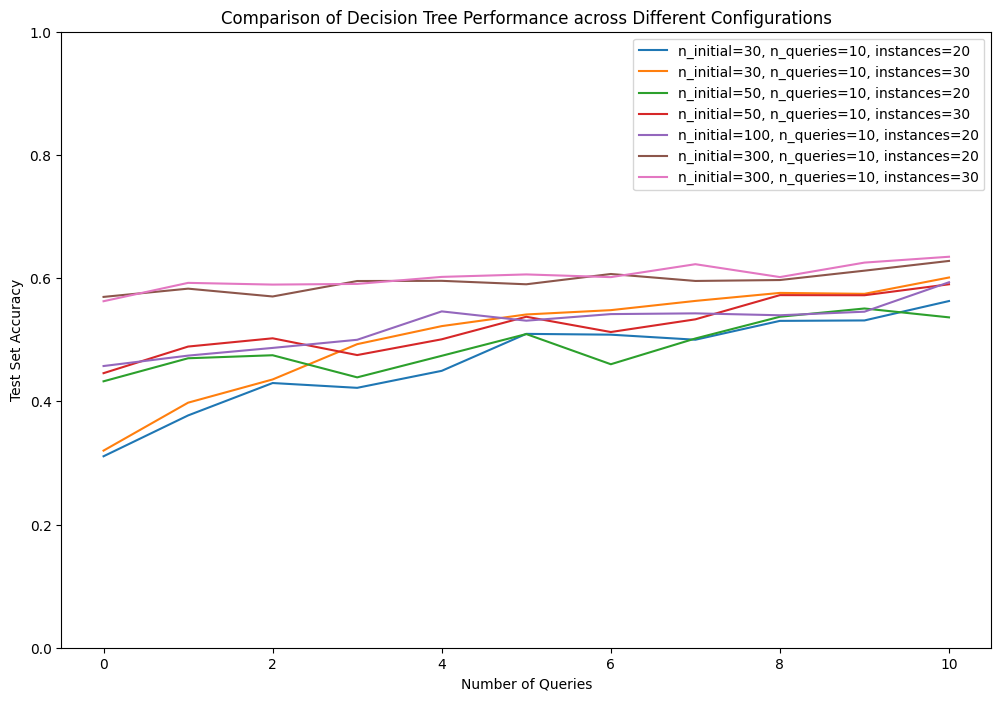

In [15]:
#plot_for_performance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.tree import DecisionTreeClassifier

# Define the active learning function with parameters for Decision Tree
def AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    learner = ActiveLearner(
        estimator=DecisionTreeClassifier(),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])

        # Remove the queried instance from the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Calculate and record performance
        model_accuracy = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(model_accuracy)

    return performance_history

# Configurations to compare
configurations = [
    (30, 10, 20),
    (30, 10, 30),
    (50, 10, 20),
    (50, 10, 30),
    (100, 10, 20),
    (300, 10, 20),
    (300, 10, 30)
]

# Run each configuration
performance_histories = {}
for config in configurations:
    n_initial, n_queries, instances = config
    performance_histories[config] = AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test)

# Plot the performances
plt.figure(figsize=(12, 8))
for config, history in performance_histories.items():
    plt.plot(history, label=f'n_initial={config[0]}, n_queries={config[1]}, instances={config[2]}')

plt.title("Comparison of Decision Tree Performance across Different Configurations")
plt.xlabel("Number of Queries")
plt.ylabel("Test Set Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.show()
